# !pip install --upgrade pip

In [ ]:
#pip install --upgrade torch torchvision


In [1]:
!pip install torch torchvision



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# imports

import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# preprocessing instantiation:
transform = {  # defined as a dictionary,
"train": transforms.Compose([
transforms.RandomHorizontalFlip(0.5), 
transforms.RandomGrayscale(0.1),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
"test": transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}# normalise with mean and standard deviation
#  scale the data to have a mean of 0 and standard deviation of 1. This can help the model train more effectively

In [4]:
batch_size = 100      # number of samples that will be passed through the model at one time during training or testing
train_data = datasets.CIFAR10('data', train=True,  
download=True, transform=transform["train"])
test_data = datasets.CIFAR10('data', train=False,  
download=True, transform=transform["test"])

# CIFAR-10:dataset used for image classification tasks,available through torchvision library.

100%|██████████| 170498071/170498071 [00:18<00:00, 9264621.45it/s] 


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
#idx = list(range(len(train_data)))
#print(idx)

In [6]:
## Using a validation size of 20%, define the training and validation sampler that will be used to divide the dataset into those 2 sets:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]
train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [7]:
print(split_size)

10000


In [8]:
## DataLoader() function to define the batches of each set of data to be used:

train_loader = torch.utils.data.DataLoader(train_data,  
batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data,  
batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data,  
batch_size=batch_size)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1) # convolutional layer 1
        self.norm1 = nn.BatchNorm2d(10)# on convolutional networks *BatchNorm2d* is used. 
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1) # convolutional layer 2
        self.norm1 = nn.BatchNorm2d(20)# on convolutional networks BatchNorm2d is used. 
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1) # convolutional layer 3
        self.norm1 = nn.BatchNorm2d(40)# on convolutional networks BatchNorm2d is used. 
        self.pool = nn.MaxPool2d(2, 2) # pooling layer (max pooling ot be specific)
        self.linear1 = nn.Linear(40 * 4 * 4, 100) # first Fully connected layer (linear)
        self.norm2 = nn.BatchNorm1d(100) # for fully connected layers *BatchNor1d* is used.
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

In [10]:
model = CNN()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [11]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []
for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    model.train()  # enables training mode
    for data, target in train_loader:
        iterations += 1
        pred = model(data)
        loss = loss_function(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target, top_class)
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        with torch.no_grad():
            model.eval()  #evaluation mode, which disables certain layers like dropout that are only used during training.
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                dev_pred = model(data_dev)
                dev_loss = loss_function(dev_pred, target_dev)
                dev_losss += dev_loss.item()
                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev,  
                dev_top_class)
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(losses/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

Epoch: 1/100..  Training Loss: 1.761..  Validation Loss: 1.488..  Training Accuracy: 0.357..  Validation Accuracy: 0.465
Epoch: 5/100..  Training Loss: 1.191..  Validation Loss: 1.090..  Training Accuracy: 0.576..  Validation Accuracy: 0.619
Epoch: 10/100..  Training Loss: 1.011..  Validation Loss: 0.954..  Training Accuracy: 0.643..  Validation Accuracy: 0.663
Epoch: 15/100..  Training Loss: 0.922..  Validation Loss: 0.865..  Training Accuracy: 0.674..  Validation Accuracy: 0.697
Epoch: 20/100..  Training Loss: 0.852..  Validation Loss: 0.826..  Training Accuracy: 0.701..  Validation Accuracy: 0.712
Epoch: 25/100..  Training Loss: 0.817..  Validation Loss: 0.782..  Training Accuracy: 0.711..  Validation Accuracy: 0.726
Epoch: 30/100..  Training Loss: 0.781..  Validation Loss: 0.775..  Training Accuracy: 0.725..  Validation Accuracy: 0.729
Epoch: 35/100..  Training Loss: 0.748..  Validation Loss: 0.744..  Training Accuracy: 0.736..  Validation Accuracy: 0.738
Epoch: 40/100..  Training 

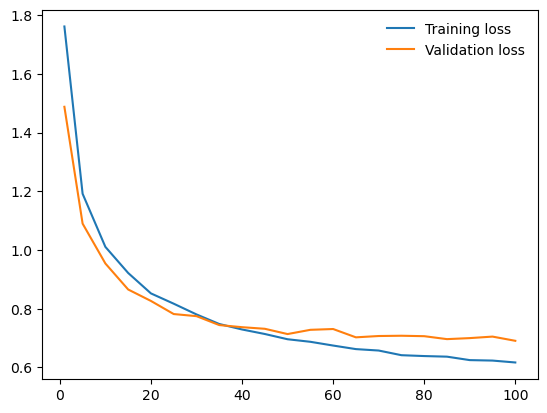

In [12]:
# plot loss
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

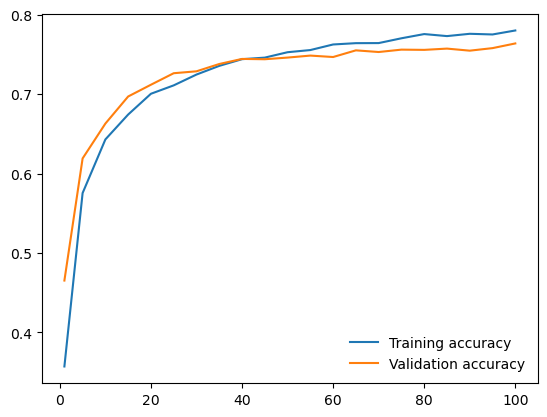

In [13]:
# plot accuracy
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [14]:
## Checking model's accuracy on the testing set
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test, top_class_test)
print(acc_test/iter_3)

0.7675000000000002
